In [18]:
import TurbPy as tb
from TurbPy.imports import *

In [19]:
# deck = 'KH_Lv1di/'
# deck = 'KH/'
# deck = 'KH_subash/'
# deck = 'KH_new/'
deck = 'KH_800ppc/'
# deck = 'KH_400ppc/'
# deck = '/GEM_feb26/'
# deck = 'turb2/'
# deck = 'turb_vth0.01/'
# deck = 'KH_beta0.1/'

dirs = '/pscratch/sd/g/goodwill/' + deck

figs = '/pscratch/sd/g/goodwill/Fig/' + deck

info = tb.get_vpic_info(dirs)
times = tb.get_times(dirs)
en_out = tb.read_energies(dirs)

twci_out = np.linspace(0, times[-1] * info['dt*wci'], len(en_out['EM']))
twce = np.linspace(0, times[-1] * info['dt*wce'], len(times))
twpe = np.linspace(0, times[-1] * info['dt*wpe'], len(times))
twci = np.linspace(0, times[-1] * info['dt*wci'], len(times))

lx = info['Lx/di']
ly = info['Ly/di']
nx = int(info['nx'])
ny = int(info['ny'])
dx = info['dx/de']
dy = info['dy/de']
dz = info['dz/de']

dt = info['dt*wce'] * info['fields_interval']

In [20]:
ds = tb.load_vars(dirs, 0, species = 'electron')

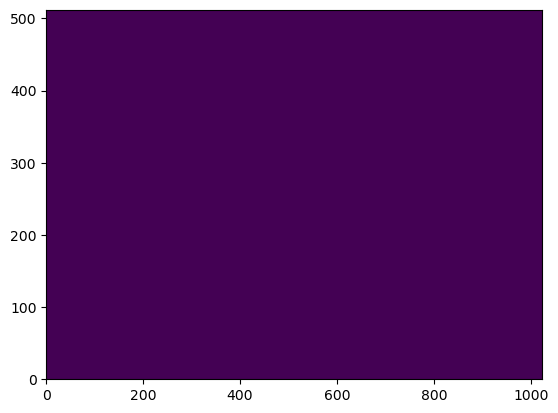

In [21]:
plt.pcolormesh(ds['ez'])

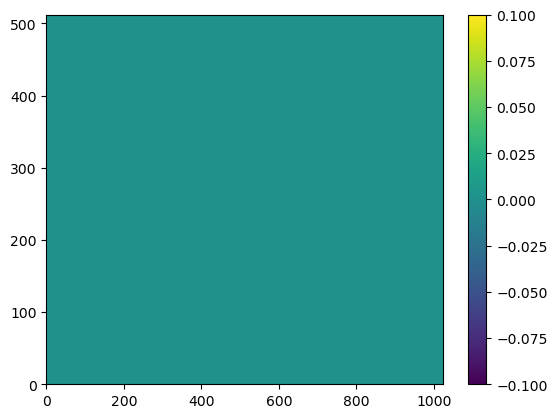

In [22]:
plt.pcolormesh(ds['cbx'])
plt.colorbar()

In [23]:
def B_interpolate(dirs, time):
  ds = tb.load_vars(dirs, time)
  Bx = (1/2) * (ds['cbx'] + np.roll(ds['cbx'], 1, axis = 0)) 
  By = (1/2) * (ds['cby'] + np.roll(ds['cby'], 1, axis = 1))
  return Bx, By

def E_interpolate(dirs, time):
  ds = tb.load_vars(dirs, time)
  ExF = (1/2) * (ds['ex'] + np.roll(ds['ex'], 1, axis = 1)) 
  EyF = (1/2) * (ds['ey'] + np.roll(ds['ey'], 1, axis = 0))
 
  Ex = (1/2) * (ExF + np.roll(ExF, 1, axis = 0)) 
  Ey = (1/2) * (EyF + np.roll(EyF, 1, axis = 1))
  return Ex, Ey

In [24]:
from TurbPy.vpic_info import *
from TurbPy.load_vars import *
import numpy as np
import pandas as pd

def JE_calc(dirs, save = True):
  vpic_info = get_vpic_info(dirs)
  times = get_times(dirs)

  dx = vpic_info['dx/de']
  
  
  ds = pd.DataFrame({'JE': [],
                     'Jx': [],
                     'Jy': [],
                     'Jz': [],
                     'Ex': [],
                     'Ey': [],
                     'Ez': []}
                     )
  # J_av = np.zeros(len(times))
  # E_av = np.zeros(len(times))
  # JE_av = np.zeros(len(times))
  # jeE_av = np.zeros(len(times))
  # jiE_av = np.zeros(len(times))
  # E_m = np.zeros(len(times))

  for t in np.arange(0,len(times), 10):
    sp = 'electron'
    jxe = load_var('jx', dirs, times[t], sp)
    jye = load_var('jy', dirs, times[t], sp)
    jze = load_var('jz', dirs, times[t], sp)

    sp = 'ion'
    jxi = load_var('jx', dirs, times[t], sp)
    jyi = load_var('jy', dirs, times[t], sp)
    jzi = load_var('jz', dirs, times[t], sp)

    jx0 = jxe + jxi
    jy0 = jye + jyi 
    jz0 = jze + jzi

    ex, ey = E_interpolate(dirs, times[t])
    # ex = load_var('ex', dirs, times[t])
    # ey = load_var('ey', dirs, times[t])
    ez = load_var('ez', dirs, times[t])

    jeE = (jxe * ex) + (jye * ey) + (jze * ez)
    jiE = (jxi * ex) + (jyi * ey) + (jzi * ez)
    JE  = (jx0 * ex) + (jy0 * ey) + (jz0 * ez)


    row = pd.DataFrame(
          {'JE': [np.average(JE) ],
           'Jx': [np.average(jx0)],
           'Jy': [np.average(jy0)],
           'Jz': [np.average(jz0)],
           'Ex': [np.average(ex) ],
           'Ey': [np.average(ey) ],
           'Ez': [np.average(ez) ]})

    ds = pd.concat([ds, row], ignore_index = True)
    # Jx_av[t] = np.average(jx0)
    # Jy_av[t] = np.average(jy0)
    # Jz_av[t] = np.average(jz0)
    # Ex_av[t] = np.average(ex)
    # Ey_av[t] = np.average(ey)
    # Ez_av[t] = np.average(ez)
    # JE_av[t]  = np.average(JE)
    # jeE_av[t] = np.average(jeE)
    # jiE_av[t] = np.average(jiE)
  if save == True:
    # pd.DataFrame({'JE': JE_av, 'Jx': J_av, 'E': E_av}).to_csv(dirs + 'JE_av.csv', sep = ',')
    ds.to_csv(dirs + 'JE_av(int).csv', sep = ',')
  return ds

def read_JE(dirs):
  ds = pd.read_csv(dirs + 'JE_av(int).csv', delimiter = ',')
  # JE = ds['JE']
  return ds

In [25]:
## Calculate ###
JE = JE_calc(dirs)
# en = tb.en_calc(dirs)

In [26]:
# ## Read ##
ds = read_JE(dirs)
ds_norm = tb.read_JE(dirs)
en = tb.read_calc_energies(dirs)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])

In [27]:
n = 0
twciN = twci[n::10]
print(twci[n])
JE_int = -sci.integrate.cumulative_trapezoid(ds['JE'][n:] * dt, initial = 0)
JE_int_norm = -sci.integrate.cumulative_trapezoid(ds_norm['JE'][n:] * dt, initial = 0)
dE = en['EM'][n:]-en['EM'][n]+en['EE'][n:]-en['EE'][n]

0.0


In [28]:
en_out = tb.read_energies(dirs)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])
dE_out = en_out['EM'][n:]-en_out['EM'][n]+en_out['EE'][n:]-en_out['EE'][n]

In [29]:
print(twciN[n:])

[  0.         24.9973308  49.9946616  74.9919924  99.9893232 124.986654
 149.9839848 174.9813156 199.9786464]


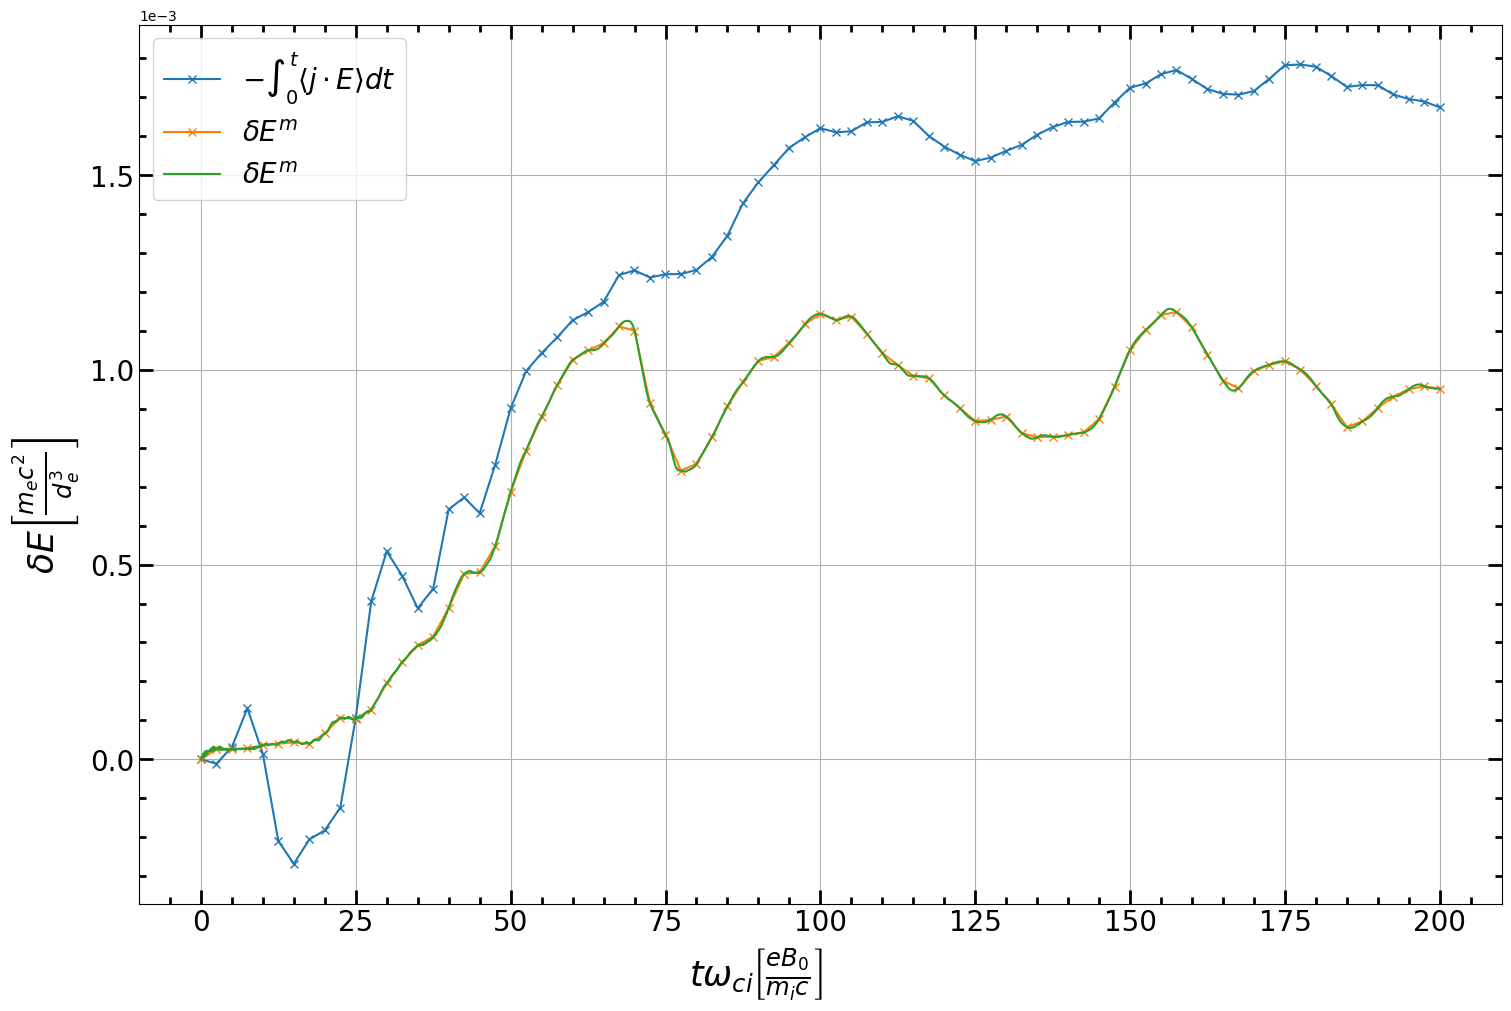

In [31]:
fig, axs = plt.subplots(1,1, figsize=(15, 10), sharex = True, layout='constrained')

# axs.plot(twciN, JE_int, marker = 'x', 
        #  label=r'$-\int_{'f'{int(np.round(twci[n],0))}'r'}^t \langle j\cdot E \rangle (inter)dt$')
axs.plot(twci, JE_int_norm, marker = 'x', 
         label=r'$-\int_{'f'{int(np.round(twci[n],0))}'r'}^t \langle j\cdot E \rangle dt$')
axs.plot(twci, dE,marker = 'x', label=r'$\delta E^m$')
axs.plot(twci_out, dE_out, label=r'$\delta E^m$')
axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
axs.legend(loc = 'upper left', fontsize = 20)
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params(which='both', width=2, labelsize = 20, right = True, direction = 'in')
axs.tick_params(which='major', length=10, top = True, right =True)
axs.tick_params(which='minor', length=5 , top = True, right =True)
axs.grid()

fig.supylabel(r'$\delta E \left[ \frac{m_e c^2}{d_e^3} \right] $', size = 25)
fig.supxlabel(r'$ t \omega_{ci} \left[ \frac{e B_0}{m_i c} \right]$', size = 25)

plt.savefig(figs + 'JE_dEM(int).jpg', dpi = 400)